In [1]:
"""
Copyright (C) 2017 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-ND 4.0 license (https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode).
"""
%matplotlib inline

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import torch
from ERSModule import *
from network import *
from torch.utils.data import Dataset, DataLoader

In [2]:
# specify gpu id
gpu_id = 0

# configurations
conn8 = 1

# number of superpixels to be tested
nC_list = [100, 200, 300, 400, 500, 600]

# the file list of test data
img_folder = '../data/groundtruth/'
img_fullpath = []
for filename in os.listdir(img_folder):
    if filename.endswith('.png'):
        img_fullpath.append(os.path.join(img_folder, filename))

print('Found %d images' % (len(img_fullpath)))
img_fullpath.sort()

# prepare output folders
imlog_dir = '../data/output'
if not os.path.exists(imlog_dir):
    os.makedirs(imlog_dir)

label_dir = []
for nC in nC_list:
    tmp_dir = os.path.join(imlog_dir, str(nC))
    label_dir.append(tmp_dir)
    if not os.path.exists(tmp_dir):
        os.makedirs(tmp_dir)

affinity_dir = os.path.join(imlog_dir, 'affinity')
if not os.path.exists(affinity_dir):
    os.makedirs(affinity_dir)

# model
model = PixelAffinityNet(nr_channel=128, conv1_size=7, use_canny=True).cuda()
# model.load_state_dict(torch.load('./bsds500.pkl', map_location=lambda storage, loc: storage))
# model.eval()
# model.cuda(gpu_id)

Found 1087 images
use_canny = True


In [3]:
# len(model.parameters)
sum(param.numel() for param in model.parameters())

888482

In [4]:
img_fullpath
dataset_ids = []
for path in img_fullpath:
    dataset_ids.append(path.split('/')[-1][:-4])

In [7]:
class PixelAffinityDataset(Dataset):
    def __init__(self, ids, path):
        self.path = path
        self.metadata = ids
        
    def __getitem__(self, index):
        pic_name = self.metadata[index]
        image = cv2.imread(self.path + '/input/' + pic_name.split('_')[0] + '.jpg')
        gt = cv2.imread(self.path + '/groundtruth/' + pic_name + '.png', -1)

        inputs = self.getInput(image)
        target = self.getTarget(gt)
#         boundaries = self.getBoundaries(gt)
        
        if inputs.shape[1] == 481:
            inputs = torch.transpose(inputs, 1, 2)
            target = torch.transpose(target, 1, 2)
#             boundaries = boundaries.transpose()
            gt = gt.transpose()
        gt = gt.astype(np.int16)
        return inputs, target, gt

    def __len__(self):
        return len(self.metadata)
    
    def getInput(self, image):
        h, w, ch = image.shape

        input1 = image.transpose((2, 0, 1))
        input1 = np.float32(input1) / 255.0
        input1 = torch.from_numpy(input1)  # input1.shape: (1, 3, 321, 481)

        # compute Canny edges
        edge = cv2.Canny(image, 50, 100)
        edge = 1. - np.float32(edge) / 255.
        edge = np.reshape(edge, [1, h, w])
        input2 = torch.from_numpy(edge)
        inputs = torch.cat((input1, input2), 0)  # (4, 321, 481)
        return inputs
    
    
    def getTarget(self, gt):
        h, w = gt.shape
        # 水平target
        horizontal = np.float32(gt[:,1:] == gt[:,:-1])
        horizontal = np.concatenate((horizontal, np.zeros((h,1),dtype='float32')), axis=1)
        input1 = np.reshape(horizontal, [1, h, w])
        input1 = torch.from_numpy(input1)
        # 水平target
        vertival = np.float32(gt[1:] == gt[:-1])
        vertival = np.concatenate((vertival, np.zeros((1,w),dtype='float32')), axis=0)
        input2 = np.reshape(vertival, [1, h, w])
        input2 = torch.from_numpy(input2)

        target = torch.cat((input1, input2), 0)
#         target = target.cuda(gpu_id, non_blocking=True)
        return target
    
#     def getBoundaries(self, gt):
#         h, w = gt.shape

#         horizontal = (gt[:, 1:-1] != gt[:, :-2]) + (gt[:, 1:-1] != gt[:, 2:])
#         horizontal = np.concatenate((np.zeros((h,1),dtype='int16'), horizontal.astype('int16'), np.zeros((h,1),dtype='int16')), axis=1)

#         vertival = ((gt[1:-1] != gt[:-2]) + (gt[1:-1] != gt[2:]))
#         vertival = np.concatenate((np.zeros((1,w),dtype='int16'), vertival.astype('int16'), np.zeros((1,w),dtype='int16')), axis=0)
#         boundaries = horizontal + vertival
#         return boundaries

In [8]:
dataset = PixelAffinityDataset(dataset_ids, '../data')
data_loader = DataLoader(dataset, batch_size=2)

inputs, target, gt = next(iter(data_loader))
inputs.shape, target.shape, gt.shape


AttributeError: 'NoneType' object has no attribute 'shape'

In [9]:
a = model(torch.rand(2,4,321,481).cuda())

In [10]:
b = torch.cat((a,a))

In [11]:
plt.figure()
plt.imshow(target[0][0], cmap='gray')
plt.show()

NameError: name 'target' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
def PAN(inputs):
    # inference
    out_x = model(inputs)  # (1, 1, 321, 481)
    inputs_t = torch.transpose(inputs, 2, 3)
    out_y_t = model(inputs_t)
    out_y = torch.transpose(out_y_t, 2, 3)
    outputs = torch.cat((out_x, out_y), 1) # (1, 2, 321, 481)

    return outputs

In [ ]:
def get_weight(gts, outputs):
    n, h, w = gts.shape
    weights = []
    for i in range(n):
        gt = gts[i]
        affinity = outputs[i]  # (2, 321, 481)
        affinity_list = affinity.flatten().tolist()
        sp_list = ERSWgtOnly(affinity_list, h, w, 100, conn8, 0.5)
        sp_label = np.reshape(np.asarray(sp_list), (h, w), order='C')

        weight = np.ones_like(gt, np.float32)

        # boundaries
        horizontal = (gt[:, 1:-1] != gt[:, :-2]) + (gt[:, 1:-1] != gt[:, 2:])
        horizontal = np.concatenate((np.zeros((321,1),dtype='int16'), horizontal.astype('int16'), np.zeros((321,1),dtype='int16')), axis=1)

        vertival = ((gt[1:-1] != gt[:-2]) + (gt[1:-1] != gt[2:]))
        vertival = np.concatenate((np.zeros((1,481),dtype='int16'), vertival.astype('int16'), np.zeros((1,481),dtype='int16')), axis=0)
        boundaries = horizontal + vertival

        dic = {}
        for y in range(0, h):
            for x in range(0, w):
                if boundaries[y][x]:
                    if (gt[y][x], sp_label[y][x]) in dic:
                        weight[y][x] = dic[(gt[y][x], sp_label[y][x])]
                        continue
                    superpixel_mask = sp_label == sp_label[y][x]
                    gt_in_sp = superpixel_mask * gt
                    if len(np.unique(gt_in_sp)) <= 2:
                        continue
                    S = sum(sum(superpixel_mask)) * 1.
                    S_G = sum(sum(gt_in_sp == gt[y][x])) * 1.
                    weight[y][x] += (S - S_G) / S
                    dic[(gt[y][x], sp_label[y][x])] = weight[y][x]
        weights.append(weight)
    return torch.from_numpy(np.array(weight))

In [ ]:
loss_list = []    

def train(model, optimiser, epochs, batch_size=2, lr=1e-4):
    for p in optimiser.param_groups : p['lr'] = lr
    criterion = nn.BCELoss().cuda()
    for e in range(epochs) :
        data_loader = DataLoader(dataset, batch_size)

        inputs, target, gt = next(iter(data_loader))

        for i, (inputs, target, gt) in enumerate(data_loader) :
            
            inputs, target = inputs.cuda(), target.cuda()

            outputs = PAN(inputs)
            weight = get_weight(gt.data.cpu().numpy(), outputs.data.cpu().numpy())
            criterion.weight = weight.cuda()
            loss = criterion(outputs, target)
            
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
#             print(loss.item())
            loss_list.append(loss.item())
            if i % 1000 == 0:
                affinity = outputs[0].data.cpu().numpy()
                plt.figure()
                plt.imshow(affinity[0], cmap='gray')
                plt.show()
        torch.save(model.state_dict(), 'model/model_'+ str(e) + '.pth')
        print(' <saved>')

In [ ]:
optimiser = torch.optim.Adam(model.parameters())

In [ ]:
# model.load_stlinear_to_melate_dict(torch.load('model/model.pyt'))
train(model, optimiser, epochs=100, batch_size=1, lr=1e-4)

In [ ]:
inputs.shape

In [ ]:
outputs = PAN(inputs.cuda())
affinity = outputs[0].data.cpu().numpy()
plt.figure()
plt.imshow(affinity[0], cmap='gray')
plt.show()

In [ ]:
plt.figure()
a = inputs[0][0]
for i in range(1,4):
    a += inputs[0][i]
plt.imshow(a, cmap='gray')
plt.show()

In [ ]:
affinity[0]

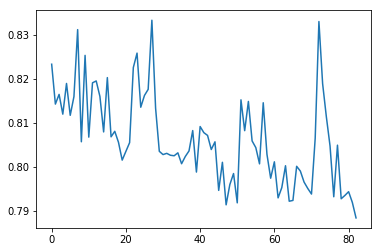

In [19]:
plt.figure()
plt.plot(loss_list)
plt.show()